In [19]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes
from source.kinetic_mechanisms import JaxKineticMechanisms as jm
from source.building_models import JaxKineticModelBuild as jkm
import jax.numpy as jnp
import jax
import numpy as np
from source.utils import get_logger
logger = get_logger(__name__)
import diffrax 
import matplotlib.pyplot as plt
import pandas as pd


/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [41]:



v1=jkm.Reaction(
    name="v1",
    species=['m1','m2'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="m1",vmax="A_Vmax",km_substrate="A_Km"),
    )

v2=jkm.Reaction(
    name="v2",
    species=['m2','m3'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="m2",vmax="B_Vmax",km_substrate="B_Km"),
    )

v3=jkm.Reaction(
    name="v3",
    species=['m2','m4'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="m2",vmax="C_Vmax",km_substrate="C_Km"),
    )




reactions=[v1,v2,v3]
compartment_values={'c':1}
kmodel=jkm.NeuralODE(reactions,compartment_values)
print(kmodel.stoichiometric_matrix)

     v1   v2   v3
m1 -1.0  0.0  0.0
m2  1.0 -1.0 -1.0
m3  0.0  1.0  0.0
m4  0.0  0.0  1.0


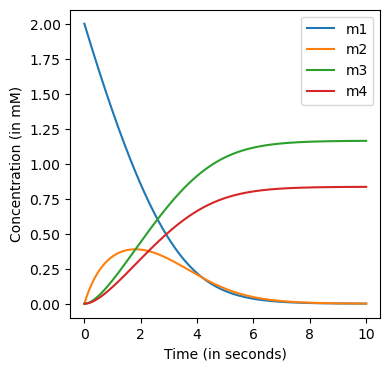

In [50]:
#define the time interval, and the initial conditions
ts=jnp.linspace(0,10,1000)
y0=jnp.array([2,0,0,0])
params=dict(zip(kmodel.parameter_names,jnp.array([1,1,1,1,1.5,1])))

#jit the kmodel object. This results in a slow initial solve, but a c-compiled solve
kmodel=jax.jit(kmodel)
ys=kmodel(ts,y0,params)
ys=pd.DataFrame(ys,columns=kmodel.species_names)

fig,ax=plt.subplots(figsize=(4,4))
ax.plot(ts,ys['m1'],label="m1")
ax.plot(ts,ys['m2'],label="m2")
ax.plot(ts,ys['m3'],label="m3")
ax.plot(ts,ys['m4'],label="m4")
ax.set_xlabel("Time (in seconds)")
ax.set_ylabel("Concentration (in mM)")
ax.legend()
fig.savefig("docs/docs/images/timeseries_example.png")